In [1]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.varmax import VARMAX
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import grangercausalitytests, adfuller
from tqdm import tqdm_notebook
from itertools import product

import matplotlib.pyplot as plt
import statsmodels.api as sm1
import pandas as pd
import numpy as np

import warnings
warnings.filterwarnings('ignore')


In [6]:
macro_data = pd.read_csv('Project_Dataset.csv',parse_dates=['year'], index_col='year')
macro_data.head()

,GHG_energy,GHG_manufacturing,GHG_Transport,GHG_Others,GHG_fugitive,GHG_Fuel_consumption,Total_GHG_emissions,FC_Energy_Industry(TJ),FC_Transport,FC_Other_Sectors
year,,,,,,,,,,
1990-01-01,0.06,0.61,1.41,1.64,0.02,3.71,3.73,"30,396.67",464.00,3702.35
1991-01-01,0.06,0.50,1.25,1.46,0.02,3.26,3.28,"32,081.27",407.56,3768.16
1992-01-01,0.06,0.61,1.38,1.49,0.02,3.54,3.56,"33,855.80",452.18,3865.47
1993-01-01,0.25,0.56,1.31,1.53,0.02,3.64,3.66,"38,199.94",428.85,3977.29
1994-01-01,0.30,0.65,1.55,1.74,0.02,4.23,4.26,"40,742.25",501.13,4154.90


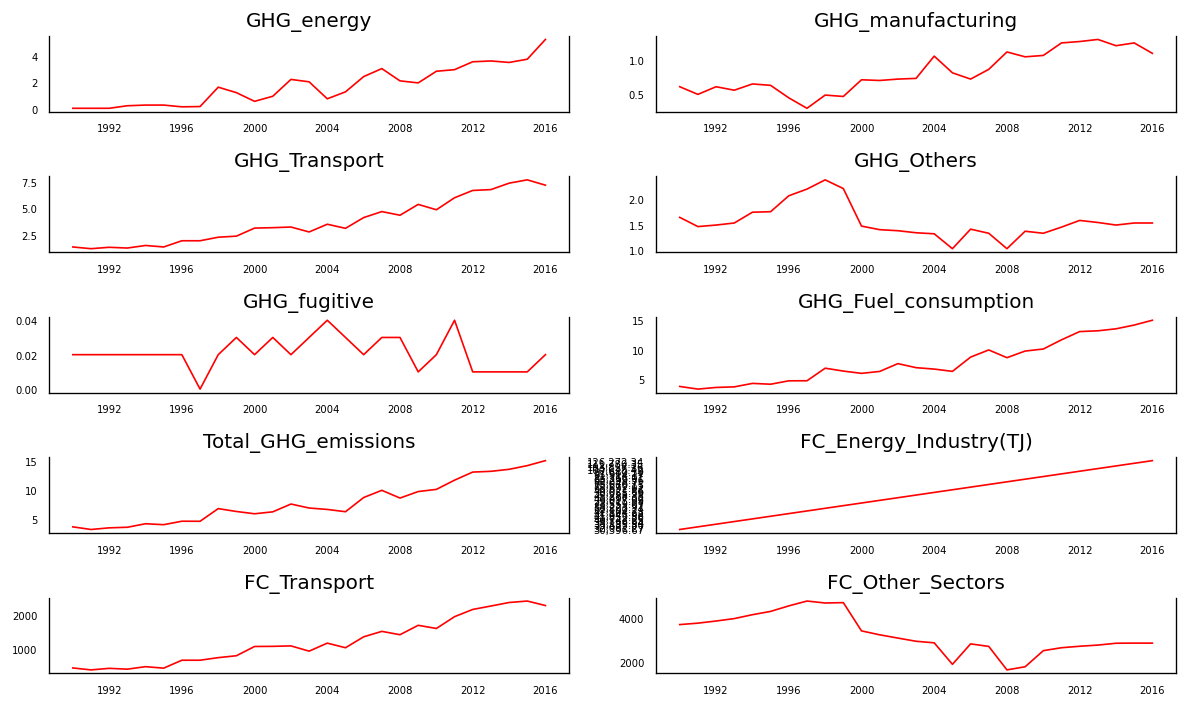

In [9]:
fig, axes = plt.subplots(nrows=5, ncols=2, dpi=120, figsize=(10,6))
for i, ax in enumerate(axes.flatten()):
    data = macro_data[macro_data.columns[i]]
    ax.plot(data, color='red', linewidth=1)
    # Decorations
    ax.set_title(macro_data.columns[i])
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)

plt.tight_layout();

Looking at the plots of the GHG emissions for the Transport and the fuel consumptions data for the Transport industry, there is a high correlation between the values. It is observed that the graphs take the same pattern in both cases and hence using a multivariate time series analysis will come in handy. The <b>VECTOR AUTOREGRESSION MODEL</b> is going to be used. 

# Running The Augmented Dickey Fuller Test
<br>
It is obvious from the graphs that the data is obtained from a non-stationary process and hence the data is non-stationary due to the obvious trend in the data.

<br>
To deal with this issue, we use the diff() method to find the difference on the data set and then we run the adfuller test to check for stationarity in the differential data.

In [98]:
ad_fuller_result_1 = adfuller(macro_data['GHG_Transport'].diff()[1:])

print('Transport Emissions')
print(f'ADF Statistic: {ad_fuller_result_1[0]}')
print(f'p-value: {ad_fuller_result_1[1]}')

print('\n---------------------\n')

ad_fuller_result_2 = adfuller(macro_data['FC_Transport'].diff()[1:])

print('Transport Fuel Consumption')
print(f'ADF Statistic: {ad_fuller_result_2[0]}')
print(f'p-value: {ad_fuller_result_2[1]}')

Transport Emissions
ADF Statistic: -7.9159995236633955
p-value: 3.834859189022213e-12

---------------------

Transport Fuel Consumption
ADF Statistic: -7.177917432250701
p-value: 2.696845188096653e-10


In [99]:
print('FC_Transport Causes GHG_Transport?\n')
print('------------------')
granger_1 = grangercausalitytests(macro_data[['GHG_Transport', 'FC_Transport']], 6)

print('\n GHG_Transport Causes FC_Transport?\n')
print('------------------')
granger_2 = grangercausalitytests(macro_data[['FC_Transport', 'GHG_Transport']], 6)

FC_Transport Causes GHG_Transport?

------------------

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=3.9040  , p=0.0603  , df_denom=23, df_num=1
ssr based chi2 test:   chi2=4.4132  , p=0.0357  , df=1
likelihood ratio test: chi2=4.0763  , p=0.0435  , df=1
parameter F test:         F=3.9040  , p=0.0603  , df_denom=23, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=1.7998  , p=0.1911  , df_denom=20, df_num=2
ssr based chi2 test:   chi2=4.4995  , p=0.1054  , df=2
likelihood ratio test: chi2=4.1374  , p=0.1263  , df=2
parameter F test:         F=1.7998  , p=0.1911  , df_denom=20, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=2.4546  , p=0.0984  , df_denom=17, df_num=3
ssr based chi2 test:   chi2=10.3959 , p=0.0155  , df=3
likelihood ratio test: chi2=8.6372  , p=0.0345  , df=3
parameter F test:         F=2.4546  , p=0.0984  , df_denom=17, df_num=3

Granger Causality
number of lags (no zero) 4

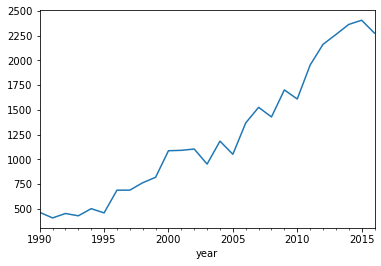

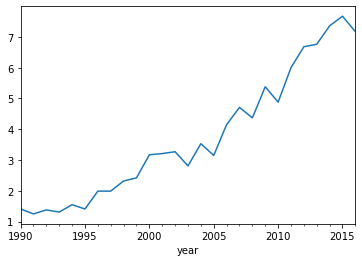

In [100]:
micro_data = macro_data[['FC_Transport','GHG_Transport']]
micro_data.FC_Transport.plot()
plt.show()
micro_data.GHG_Transport.plot()
plt.show()

In [84]:
train_df=micro_data[:-5]
test_df=micro_data[-5:]

In [85]:
model = VAR(train_df.diff()[1:])

In [87]:

sorted_order=model.select_order(maxlags=6)
print(sorted_order.summary())

 VAR Order Selection (* highlights the minimums) 
      AIC         BIC         FPE         HQIC   
-------------------------------------------------
0       5.385       5.479       218.2       5.384
1       4.967      5.250*      145.2*       4.964
2       5.306       5.778       212.4       5.301
3       5.554       6.215       302.1       5.547
4       4.957       5.807       206.4       4.948
5       5.037       6.075       346.2       5.026
6      4.826*       6.053       763.1      4.813*
-------------------------------------------------


In [92]:
var_model = VARMAX(train_df, order=(6,0),enforce_stationarity= True)
fitted_model = var_model.fit(disp=False)
print(fitted_model.summary())

                                   Statespace Model Results                                  
Dep. Variable:     ['FC_Transport', 'GHG_Transport']   No. Observations:                   22
Model:                                        VAR(6)   Log Likelihood                -112.427
                                         + intercept   AIC                            282.855
Date:                               Sun, 08 Jan 2023   BIC                            314.495
Time:                                       15:02:21   HQIC                           290.308
Sample:                                   01-01-1990                                         
                                        - 01-01-2011                                         
Covariance Type:                                 opg                                         
Ljung-Box (L1) (Q):             1.20, 0.00   Jarque-Bera (JB):           0.13, 8.86
Prob(Q):                        0.27, 0.96   Prob(JB):                

In [95]:
n_forecast = 6
predict = fitted_model.get_prediction(start=len(train_df),end=len(train_df) + n_forecast-1)#start="2010-01-01",end='-01-01')

predictions=predict.predicted_mean

In [96]:
predictions.columns=['Predicted FC_Transport','predicted GHG_Transport']
predictions

,Predicted FC_Transport,predicted GHG_Transport
2012-01-01,888.191732,2.711949
2013-01-01,1000.236112,3.103827
2014-01-01,412.477691,1.237227
2015-01-01,472.351850,1.438419
2016-01-01,118.404652,0.414532
2017-01-01,111.348061,0.361855


In [82]:
test_vs_pred=pd.concat([test_df,predictions],axis=1)

<AxesSubplot:>

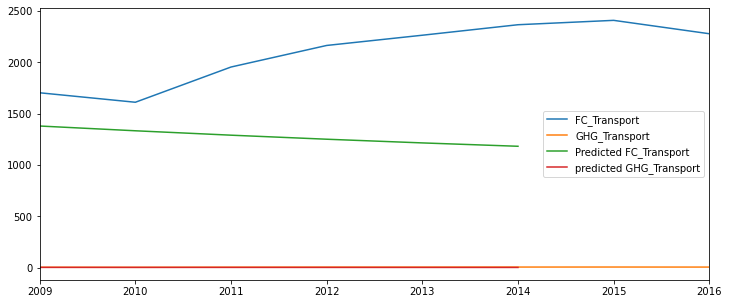

In [83]:
test_vs_pred.plot(figsize=(12,5))